# Catboost Model
## Tree based model using sturtural analysis of webpages to detect 404-error pages

Importing Libraries

In [8]:
import os 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import  OneHotEncoder
from matplotlib import pyplot as plt
from tqdm import tqdm
import catboost as cb
from catboost import CatBoostClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, precision_score



sns.set()

%config InlineBackend.figure_format = 'retina'

Importing data in form of Csv and preprocesing it 


In [2]:
df= pd.read_csv("Updated_data.csv")
df= df.sample(frac=1, random_state=42)
df=df.reset_index(drop=True)
df.head()



,Url,size_total,Load_time,image_count,Image_unreachable,Average_word_length,Ratio,image_size_total,matched_keywords,number_of_words,Script_size,Css_size,response_status_code,is_dead,prob
0,http://www.logodesign.com/,226,1.784024,0,0,54.000000,1.000000,0,1,2,0,0,406,True,0.357632
1,http://www.lolaart.net/,6909,5.193232,0,0,10.539568,1.000000,0,8,7,0,0,521,True,0.239705
2,http://www.nmpros.com/,226,1.368218,0,0,54.000000,1.000000,0,1,2,0,0,406,True,0.357632
3,http://www.aaacpc.com/,4713,0.694305,1,1,16.382716,1.000000,0,0,4,0,0,403,False,0.000000
4,http://www.acoustic-energy.co.uk/,108809,10.885103,11,0,51.508753,-4.994091,652211,10,7,16719,5951,200,False,0.000000


C:\Users\manis\AppData\Local\Temp\ipykernel_6296\1893099257.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corrMatrix = df.corr()


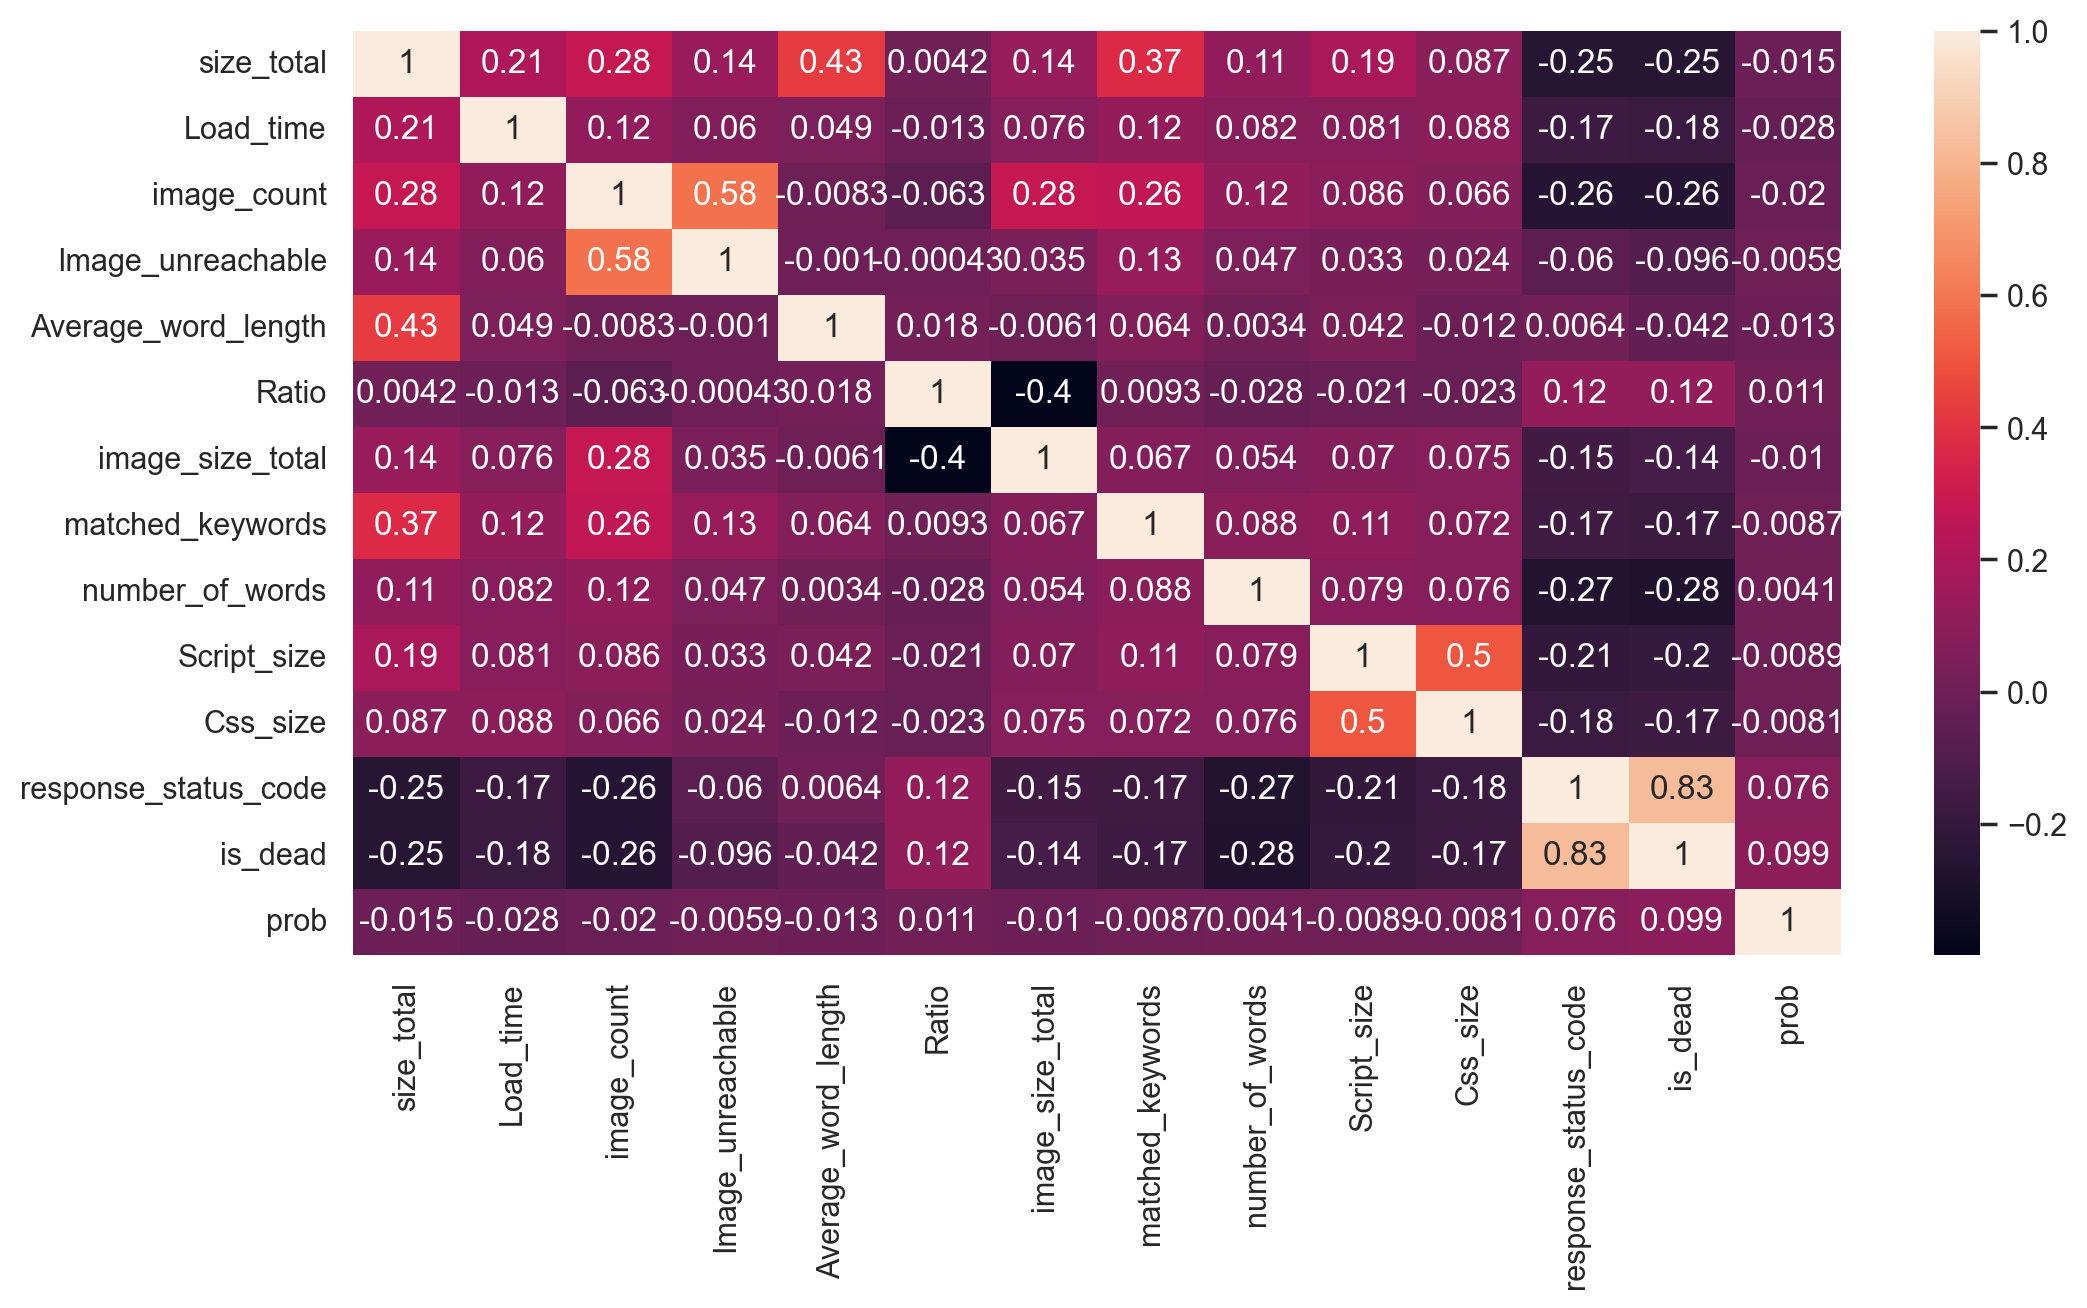

In [3]:
corrMatrix = df.corr()
# size of the plot
plt.figure(figsize=(12, 6))
# correaltion matrix
sns.heatmap(corrMatrix, annot=True)
plt.show()

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 166300 entries, 0 to 166299
Data columns (total 15 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Url                   166300 non-null  object 
 1   size_total            166300 non-null  int64  
 2   Load_time             166300 non-null  float64
 3   image_count           166300 non-null  int64  
 4   Image_unreachable     166300 non-null  int64  
 5   Average_word_length   166300 non-null  float64
 6   Ratio                 166300 non-null  float64
 7   image_size_total      166300 non-null  int64  
 8   matched_keywords      166300 non-null  int64  
 9   number_of_words       166300 non-null  int64  
 10  Script_size           166300 non-null  int64  
 11  Css_size              166300 non-null  int64  
 12  response_status_code  166300 non-null  int64  
 13  is_dead               166300 non-null  bool   
 14  prob                  166300 non-null  float64
dtype

In [5]:
drop_column = ['Url','is_dead','Image_unreachable','prob']
df.drop(drop_column, axis=1, inplace = True)
#df['is_dead'] = df['is_dead'].astype(int)
df.loc[ df['response_status_code'] <= 205, 'response_status_code'] = int(0)
df.loc[df['response_status_code'] > 205 , 'response_status_code'] = int(1)
df.head()


,size_total,Load_time,image_count,Average_word_length,Ratio,image_size_total,matched_keywords,number_of_words,Script_size,Css_size,response_status_code
0,226,1.784024,0,54.000000,1.000000,0,1,2,0,0,1
1,6909,5.193232,0,10.539568,1.000000,0,8,7,0,0,1
2,226,1.368218,0,54.000000,1.000000,0,1,2,0,0,1
3,4713,0.694305,1,16.382716,1.000000,0,0,4,0,0,1
4,108809,10.885103,11,51.508753,-4.994091,652211,10,7,16719,5951,0


Splitting data into training validation and testing datasets
Training a Catboost model on the same

In [9]:
# Split the data into train, test, and validation sets
train_df, val_df = train_test_split(df, test_size=0.1, random_state=42)
test_df, val_df = train_test_split(val_df, test_size=0.5, random_state=42)

# Define the input features and target variable
features = train_df.columns.tolist()
features.remove('response_status_code')

X_train, y_train = train_df[features], train_df['response_status_code']
X_val, y_val = val_df[features], val_df['response_status_code']
X_test, y_test = test_df[features], test_df['response_status_code']

print("Train set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Test set shape:", X_test.shape, y_test.shape)
#  Create the CatBoost model
model = cb.CatBoostClassifier(
    iterations=1000,  # Set the number of boosting iterations
    learning_rate=0.03,  # Set the learning rate
    depth=15 , # Set the depth of each tree
    task_type="GPU",
                           devices='0',border_count=64,l2_leaf_reg=3
)

# Fit the model on the training data
model.fit(X_train, y_train, eval_set=(X_val, y_val), verbose=100)

# Evaluate the model on the test data
accuracy = model.score(X_test, y_test)
print(f"Accuracy on test set: {accuracy}")


Train set shape: (149670, 10) (149670,)
Validation set shape: (8315, 10) (8315,)
Test set shape: (8315, 10) (8315,)
0:	learn: 0.6391871	test: 0.6385380	best: 0.6385380 (0)	total: 370ms	remaining: 6m 9s
100:	learn: 0.1357777	test: 0.1513690	best: 0.1513690 (100)	total: 34.3s	remaining: 5m 5s
200:	learn: 0.1127590	test: 0.1467138	best: 0.1467138 (200)	total: 1m 10s	remaining: 4m 39s
300:	learn: 0.0963503	test: 0.1458000	best: 0.1457526 (297)	total: 1m 44s	remaining: 4m 3s
400:	learn: 0.0828065	test: 0.1459287	best: 0.1455510 (333)	total: 2m 18s	remaining: 3m 26s
500:	learn: 0.0720718	test: 0.1468004	best: 0.1455510 (333)	total: 2m 52s	remaining: 2m 51s
600:	learn: 0.0635344	test: 0.1483057	best: 0.1455510 (333)	total: 3m 27s	remaining: 2m 17s
700:	learn: 0.0561691	test: 0.1497067	best: 0.1455510 (333)	total: 4m 1s	remaining: 1m 43s
800:	learn: 0.0503449	test: 0.1508048	best: 0.1455510 (333)	total: 4m 35s	remaining: 1m 8s
900:	learn: 0.0452019	test: 0.1523641	best: 0.1455510 (333)	total: 

In [ ]:
#accuracy = model.score(X_train, y_train)
#print(f"Accuracy on test set: {accuracy}")

Saving model to be used futher

In [ ]:
model.save_model('catboost_model.bin')


In [ ]:
loaded_model = CatBoostClassifier()
loaded_model.load_model('catboost_model.bin')

Testing to get a confusion matrix 

In [ ]:
predictions = loaded_model.predict(X_test)
print(len(X_test))
print(len(predictions))
print(len(X_test))

In [ ]:
accuracy = accuracy_score(y_test,predictions)
print("Accuracy:", accuracy)
recall = recall_score(y_test, predictions)
print("Recall:", recall)
precision = precision_score(y_test, predictions)
print("Precision:", precision)
cm = confusion_matrix(y_test, predictions)

# Plot the confusion matrix
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(np.unique(y_test)))
plt.xticks(tick_marks, np.unique(y_test))
plt.yticks(tick_marks, np.unique(y_test))
plt.xticks(tick_marks, ['200 OK', '404 Error'])
plt.yticks(tick_marks, ['200 OK', '404 Error'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()


## HyperParameters Tuning 
Define the parameters in m_parameters and state few desired value of hyperparameter
This will run model with each set of values of parameters and later u can compared the results to find the best fit.


In [ ]:
from catboost import CatBoostClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(df, test_size=0.3, random_state=42)
test_df, val_df = train_test_split(val_df, test_size=0.2, random_state=42)

# Define the input features and target variable
features = train_df.columns.tolist()
features.remove('response_status_code')

X_train, y_train = train_df[features], train_df['response_status_code']
X_val, y_val = val_df[features], val_df['response_status_code']
X_test, y_test = test_df[features], test_df['response_status_code']


print("Train set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Test set shape:", X_test.shape, y_test.shape)

# Define the CatBoost model
MOD = CatBoostClassifier(task_type="GPU",
                           devices='0',verbose=200)

# Define the parameter grid for RandomizedSearchCV
m_params = {
    "depth": [15,16,18,20],#6,10,11,12,
    "learning_rate": [0.01, 0.05, 0.1,0.03,0.001,0.003,0.005],
    "l2_leaf_reg": [1, 3],
    "iterations": [2000],
    "border_count": [32, 64, 128]
}

scoreFunction = { "precision": "precision","recall": "recall"}

random_search = RandomizedSearchCV(
    MOD,
    param_distributions=m_params,
    n_iter=20,
    scoring=scoreFunction,
    refit="recall",
    return_train_score=True,
    random_state=42,
    cv=5,
    verbose=200
)

# Train and optimize the model
random_search.fit(X_train, y_train,eval_set=(X_val, y_val))

# Recover the best model
MOD = random_search.best_estimator_
